### Requirements Gathering

#### Business Problem
Bank Republik sedang menghadapi tantangan terkait **peningkatan Non-Performing Loan (NPL)** yang berdampak pada stabilitas keuangan dan profitabilitas. Untuk mengatasi hal ini, Bank Republik membutuhkan sebuah sistem prediksi yang mampu **mendeteksi kemungkinan credit default** berdasarkan data demografi dan finansial peminjam.

#### Business Objective
1. Memprediksi potensi credit risk secara akurat sebelum keputusan pinjaman diberikan.
2. Mengidentifikasi faktor-faktor utama yang berkontribusi terhadap kemungkinan kredit bermasalah.
3. Meningkatkan efektivitas proses penilaian kredit, sehingga mampu meminimalkan potensi NPL di masa mendatang.

#### Modeling Task
Untuk melakukan prediksi risiko kredit, pendekatan Machine Learning yang digunakan meliputi:

- Baseline Model: Menggunakan kelas mayoritas untuk mengukur performa awal.
- Vanilla Model: Model sederhana menggunakan Logistic Regression sebagai model awal.
- Multiple Model + Hyperparameter Tuning: Mencoba berbagai model klasifikasi (seperti Random Forest, XGBoost, dll.) dengan optimasi parameter untuk meningkatkan akurasi.
- Model Terbaik (Best Model): Memilih model dengan performa terbaik berdasarkan hasil evaluasi.

**Metrics:** Model dievaluasi menggunakan F2 Score, yang lebih menekankan pada recall untuk memastikan kemampuan model dalam mendeteksi kasus default secara akurat

### Data Pipeline

In [1]:
import yaml
import joblib
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

c:\Users\diana\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def dump_joblib(data, path):
    joblib.dump(data, path)

def load_joblib(path):
    return joblib.load(path)

In [3]:
def load_params(params_dir):
    with open(params_dir, 'r') as file:
        params = yaml.safe_load(file)

    return params

In [4]:
params = load_params(params_dir="config/config.yaml")
params

{'dataset_dump_path': {'raw': 'data/raw/',
  'interim': 'data/interim/',
  'processed': 'data/processed/'},
 'target_col': 'loan_status',
 'int64_columns': ['person_age',
  'person_income',
  'loan_amnt',
  'loan_status',
  'cb_person_cred_hist_length'],
 'float_columns': ['person_emp_length',
  'loan_int_rate',
  'loan_percent_income'],
 'object_columns': ['person_home_ownership',
  'loan_intent',
  'loan_grade',
  'cb_person_default_on_file'],
 'value_person_home_ownership': ['RENT', 'OWN', 'MORTGAGE', 'OTHER'],
 'value_loan_intent': ['PERSONAL',
  'EDUCATION',
  'MEDICAL',
  'VENTURE',
  'HOMEIMPROVEMENT',
  'DEBTCONSOLIDATION'],
 'value_loan_grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
 'value_cb_person_default_on_file': ['Y', 'N'],
 'label_encoder_columns': ['loan_grade'],
 'ohe_columns': ['person_home_ownership',
  'loan_intent',
  'cb_person_default_on_file'],
 'feature_num_columns': ['person_age',
  'person_income',
  'loan_amnt',
  'cb_person_cred_hist_length',
  'person_emp_l

#### Data Ingestion

In [5]:
# init variables to store the values from .env

DB_HOST = "ep-autumn-bar-a1ubq400.ap-southeast-1.aws.neon.tech"
DB_USER = "siswa_bfp"
DB_PASS = "bfp_aksel_keren"
DB_NAME = "credit_risk_db"
DB_PORT = "5432"

In [6]:
# create a function to connect to the database
def init_engine():
    db_conn = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

    return db_conn

In [7]:
conn = init_engine()

try:
    query = 'select * from credit_risk'
    df = pd.read_sql(sql = query, con = conn)

except Exception as e:
    raise Exception(f"Error Message: {e}")

finally:
    conn.dispose()

In [8]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [9]:
dump_joblib(data=df, path=params["dataset_dump_path"]["raw"] + "raw_data.pkl")

#### Data Definition

- person_age: Person's age
- person_income: Person's annual income
- person_home_ownership: Home ownership
- person_emp_length: Employment length (in years)
- loan_intent: Loan intent
- loan_grade: Loan grade
- loan_amnt: Loan amount
- loan_int_rate: Interest rate
- loan_status: Loan status (0 is non default 1 is default)
- loan_percent_income: Percent income
- cb_person_default_on_file: Historical default
- cb_preson_cred_hist_length: Credit history length

#### Data Validation

In [10]:
# check data shape
print(f'Data shape: {df.shape}')

Data shape: (32581, 12)


In [11]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  object 
 1   person_income               32581 non-null  object 
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 3.0+ MB


In [12]:
# change inconsistent data types
df['person_age'] = df['person_age'].astype('int64')
df['person_income'] = df['person_income'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [13]:
# check number of missing values
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

loan_int_rate                 9.563856
person_emp_length             2.747000
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

- Terdapat missing value pada column loan interest rate dan person employee lenght.
- Diperlukan handling pada columns ini.

In [14]:
# check duplicated data
print(f'Number of duplicated data: {df.duplicated().sum()}')

Number of duplicated data: 165


- Ada data yang duplikat, sehingga perlu untuk dilakukan pengecekan lebih lanjut.

In [15]:
df[df.duplicated()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [16]:
df[(df['person_age'] == 23) & (df['person_income'] == 42000) & (df['loan_int_rate'] == 9.99)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
6464,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4


In [17]:
df = df.drop_duplicates(keep='first')
print(f'Number of duplicated data: {df.duplicated().sum()}')

Number of duplicated data: 0


In [18]:
# check data describe
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32416.000000,3.241600e+04,31529.00000,32416.000000,29321.000000,32416.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.79051,9593.845632,11.017265,0.218688,0.170250,5.811297
std,6.354100,6.201558e+04,4.14549,6322.730241,3.241680,0.413363,0.106812,4.059030
min,20.000000,4.000000e+03,0.00000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.854200e+04,2.00000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.00000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.921800e+04,7.00000,12250.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.00000,35000.000000,23.220000,1.000000,0.830000,30.000000


#### Data Defense

In [19]:
def check_data(input_data, params):
    try:
        print("===== Start Data Defense Checker =====")
        # check data types
        assert input_data.select_dtypes('object').columns.to_list() == params['object_columns'], 'an error occurs in object column(s)'
        assert input_data.select_dtypes('float').columns.to_list() == params['float_columns'], 'an error occurs in float column(s)'
        assert input_data.select_dtypes('int64').columns.to_list() == params['int64_columns'], 'an error occurs in integer column(s)'

        # check values
        assert set(input_data[params['object_columns'][0]]).issubset(set(params['value_person_home_ownership'])), 'an error occurs in person home ownership column'
        assert set(input_data[params['object_columns'][1]]).issubset(set(params['value_loan_intent'])), 'an error occurs in loan intent column'
        assert set(input_data[params['object_columns'][2]]).issubset(set(params['value_loan_grade'])), 'an error occurs in loan grade column'
        assert set(input_data[params['object_columns'][3]]).issubset(set(params['value_cb_person_default_on_file'])), 'an error occurs in cb person default on file column'
    
    except Exception:
        raise Exception("Failed Data Defense Checker")
    
    finally:
        print("===== Finish Data Defense Checker =====")

In [20]:
check_data(input_data=df, params=params)

===== Start Data Defense Checker =====
===== Finish Data Defense Checker =====


#### Data Splitting

In [21]:
def split_data(data: pd.DataFrame, params: dict) -> None:
    # set params
    data_dump_raw = params['dataset_dump_path']['raw']
    data_dump_interim = params['dataset_dump_path']['interim']
    target_col = params['target_col']

    # set target col
    y = data[target_col]
    X = data.drop(columns=target_col, axis=1)

    # validation
    print(f'Feature shape: {X.shape}')
    print(f'Target shape: {y.shape}')

    # save the X and y to pkl
    joblib.dump(X, data_dump_raw + "X.pkl")
    joblib.dump(y, data_dump_raw + "y.pkl")

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size = 0.2,
        random_state = 42,
        stratify = y)
    
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_test,
        y_test,
        test_size = 0.2,
        random_state = 42,
        stratify = y_test)
    
    # validation
    print('X_train shape :', X_train.shape)
    print('y_train shape :', y_train.shape)
    print('X_valid shape  :', X_valid.shape)
    print('y_valid shape  :', y_valid.shape)
    print('X_test shape  :', X_test.shape)
    print('y_test shape  :', y_test.shape)    
    
    # dump
    joblib.dump(X_train, data_dump_interim + "X_train.pkl")
    joblib.dump(y_train, data_dump_interim + "y_train.pkl")
    joblib.dump(X_valid, data_dump_interim + "X_valid.pkl")
    joblib.dump(y_valid, data_dump_interim + "y_valid.pkl")
    joblib.dump(X_test, data_dump_interim + "X_test.pkl")
    joblib.dump(y_test, data_dump_interim + "y_test.pkl")

In [22]:
split_data(data=df, params=params)

Feature shape: (32416, 11)
Target shape: (32416,)
X_train shape : (25932, 11)
y_train shape : (25932,)
X_valid shape  : (5187, 11)
y_valid shape  : (5187,)
X_test shape  : (1297, 11)
y_test shape  : (1297,)


### Exploratory Data Analysis

In [23]:
DATA_INTERIM_PATH = params["dataset_dump_path"]["interim"]
DATA_INTERIM_PATH

'data/interim/'

In [24]:
X_train = joblib.load(DATA_INTERIM_PATH + "X_train.pkl")
y_train = joblib.load(DATA_INTERIM_PATH + "y_train.pkl")

df_eda = pd.concat([X_train, y_train], axis=1)
df_eda

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
7173,23,75800,RENT,0.0,PERSONAL,A,7000,6.54,0.09,N,2,0
16396,25,61959,RENT,9.0,EDUCATION,C,25000,12.73,0.40,Y,4,1
21744,31,53088,RENT,0.0,PERSONAL,A,6000,6.54,0.11,N,9,0
27805,27,228000,MORTGAGE,12.0,HOMEIMPROVEMENT,A,6000,7.14,0.03,N,6,0
24563,29,54000,RENT,0.0,PERSONAL,D,10000,14.96,0.19,N,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1233,23,25000,MORTGAGE,4.0,MEDICAL,A,5000,9.32,0.20,N,2,0
741,22,21600,MORTGAGE,NaN,EDUCATION,A,4025,5.42,0.19,N,4,0
21985,28,81000,RENT,13.0,VENTURE,A,6225,7.90,0.08,N,7,0
26335,30,100000,MORTGAGE,13.0,PERSONAL,A,10000,6.17,0.10,N,9,0


#### Loan Status

In [69]:
status_counts = df_eda['loan_status'].value_counts()
status_counts

loan_status
0    20261
1     5671
Name: count, dtype: int64

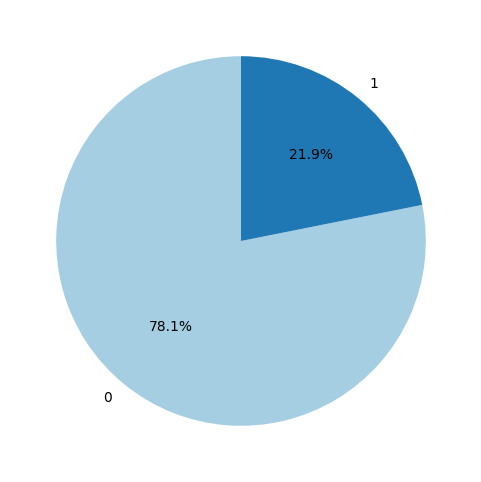

In [26]:
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.show()

- Ada sebanyak 21.9% peminjam yang mengalami gagal bayar.

#### Person Age

In [27]:
df_eda['person_age'].value_counts().head()

person_age
23    3126
22    2873
24    2809
25    2432
26    1985
Name: count, dtype: int64

<Axes: xlabel='person_age'>

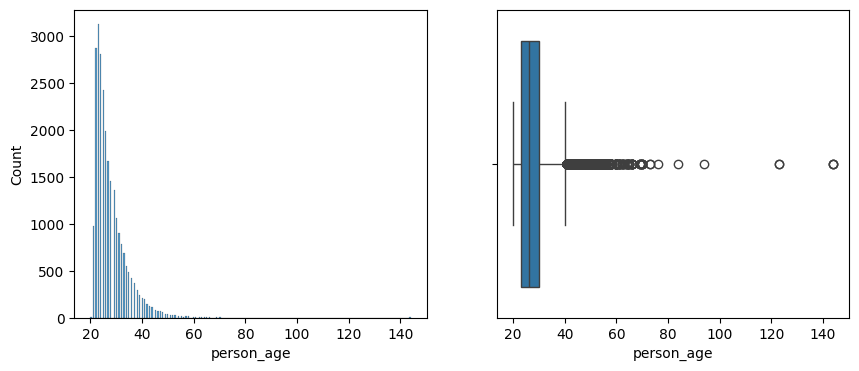

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda, x='person_age', ax=ax[0])
sns.boxplot(data=df_eda, x='person_age', ax=ax[1])

- Distribusi right skewed, dengan mayoritas nilai pada rentang usia 20-30 tahunan.
- Ada beberapa outlier mencapai 144 tahun, perlu dilakukan handling.

<Axes: xlabel='loan_status', ylabel='person_age'>

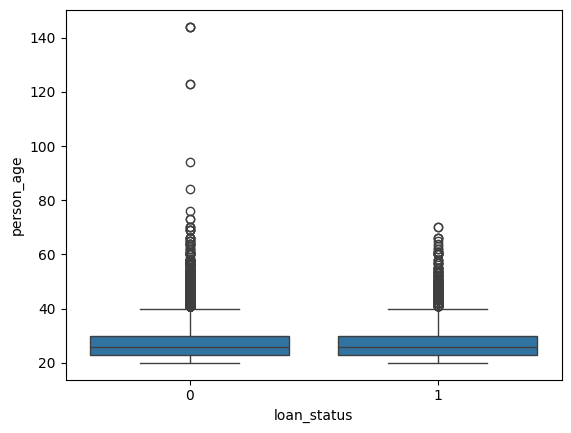

In [29]:
sns.boxplot(data=df_eda, x='loan_status', y='person_age')

- Karena adanya outlier, tidak terlihat perbedaan signifikan antara umur nasabah yang default dan non default.
- Dilakukan filtering pada usia < 80 tahun, untuk melihat distribusi kedua kelas.

In [72]:
df_eda[df_eda['person_age'] > 80]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0.26,N,4,0
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2,0
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0.11,N,24,0
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3,0
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25,0
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3,0
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0.27,N,27,0


<Axes: xlabel='person_age'>

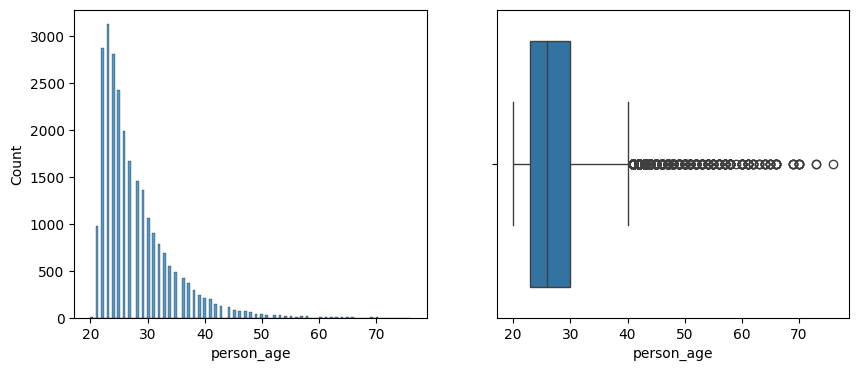

In [70]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda[df_eda['person_age'] < 80], x='person_age', ax=ax[0])
sns.boxplot(data=df_eda[df_eda['person_age'] < 80], x='person_age', ax=ax[1])

<Axes: xlabel='loan_status', ylabel='person_age'>

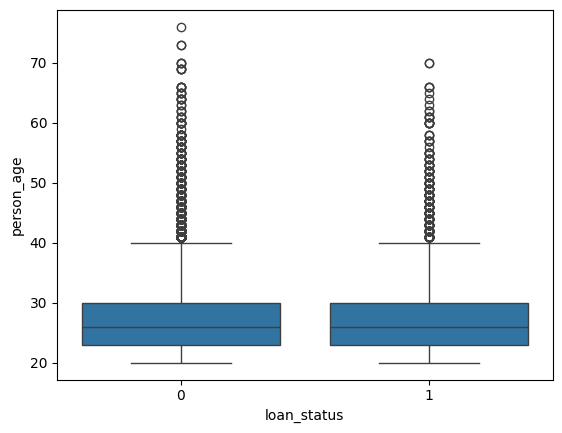

In [73]:
sns.boxplot(data=df_eda[df_eda['person_age'] < 80], x='loan_status', y='person_age')

- Distribusi skewed, dengan nilai tengah pada usia 25 tahunan.
- Artinya 50% nasabah yang memninjam memiliki usia kurang dari 25 tahun.
- Ada beberapa nasabah yang berusia lanjut (>60 tahun) tetap diapprove.
- Tidak ada perbedaan yang signifikan antara usia yang gagal bayar dan berhasil bayar.

#### Person Income

In [74]:
df['person_income'].value_counts().head()

person_income
60000    1040
30000     844
50000     772
40000     655
45000     586
Name: count, dtype: int64

<Axes: xlabel='person_income'>

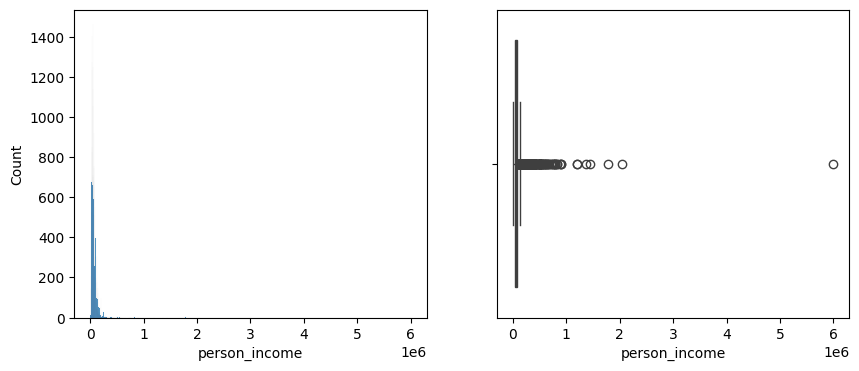

In [75]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda, x='person_income', ax=ax[0])
sns.boxplot(data=df_eda, x='person_income', ax=ax[1])

- Distribusi sangat skewed.
- Ada potensi outlier pada income yang >= $6.000.000, perlu dilakukan identifikasi lebih lanjut.
- Mayoritas nasabah memiliki pendapatan sebesar $60.000.

<Axes: xlabel='loan_status', ylabel='person_income'>

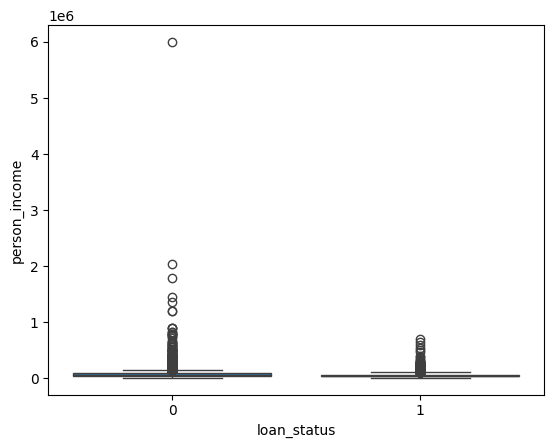

In [76]:
sns.boxplot(data=df_eda, x='loan_status', y='person_income')

Filtering income >= $1.000.000 untuk melihat perbedaan distribusi antara kedua kelas (default dan non-default).

In [79]:
df_eda[df_eda['person_income'] > 1000000]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
31922,47,1362000,MORTGAGE,9.0,VENTURE,A,6600,7.74,0.00,N,17,0
17833,32,1200000,MORTGAGE,1.0,VENTURE,A,12000,7.51,0.01,N,8,0
29120,40,1200000,MORTGAGE,1.0,MEDICAL,A,10000,NaN,0.01,N,16,0
31924,44,1440000,MORTGAGE,7.0,DEBTCONSOLIDATION,A,6400,7.40,0.00,N,15,0
32497,63,1782000,RENT,13.0,EDUCATION,C,12025,14.27,0.01,N,30,0
30049,42,2039784,RENT,0.0,VENTURE,C,8450,12.29,0.00,Y,15,0
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25,0


<Axes: xlabel='person_income'>

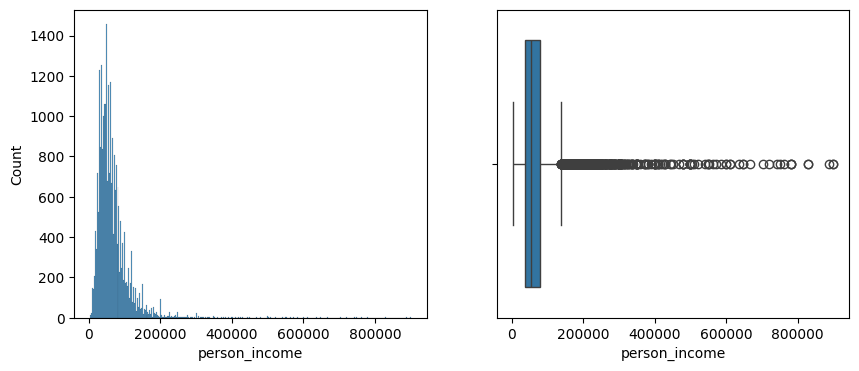

In [80]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda[df_eda['person_income'] < 1000000], x='person_income', ax=ax[0])
sns.boxplot(data=df_eda[df_eda['person_income'] < 1000000], x='person_income', ax=ax[1])

<Axes: xlabel='loan_status', ylabel='person_income'>

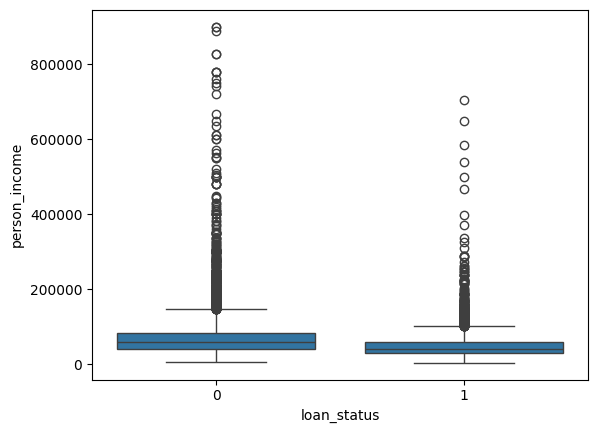

In [81]:
sns.boxplot(data=df_eda[df_eda['person_income'] < 1000000], x='loan_status', y='person_income')

- Terdapat sedikit perbedaan antara income dari credit default dan non-default.
- Pada credit default cenderung memiliki income yang lebih rendah, dengan median dan nilai maksimum yang lebih rendah.

#### Person Home Ownership

In [37]:
df_eda['person_home_ownership'].value_counts(normalize=True)

person_home_ownership
RENT        0.505707
MORTGAGE    0.412155
OWN         0.078744
OTHER       0.003393
Name: proportion, dtype: float64

<Axes: xlabel='person_home_ownership', ylabel='count'>

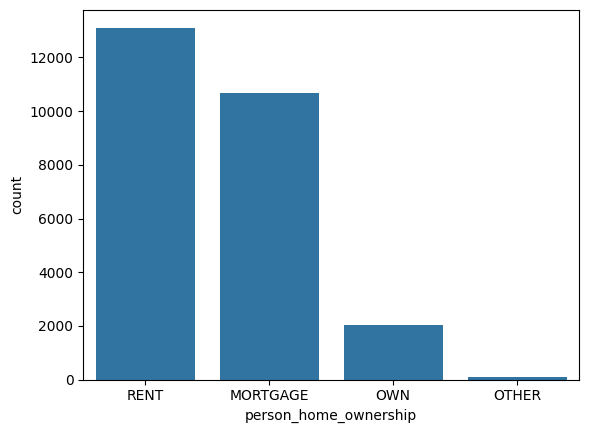

In [38]:
sns.countplot(data=df_eda, x='person_home_ownership')

- Sebanyak 50% nasabah memiliki status kepemilikan rumah sebagai penyewa, diikuti dengan 41% dengan status KPR.

In [39]:
non_default_home = df_eda[df_eda['loan_status'] == 0]['person_home_ownership'].value_counts(normalize=True)
non_default_home

person_home_ownership
MORTGAGE    0.461132
RENT        0.442278
OWN         0.093579
OTHER       0.003011
Name: proportion, dtype: float64

In [40]:
default_home = df_eda[df_eda['loan_status'] == 1]['person_home_ownership'].value_counts(normalize=True)
default_home

person_home_ownership
RENT        0.732322
MORTGAGE    0.237172
OWN         0.025745
OTHER       0.004761
Name: proportion, dtype: float64

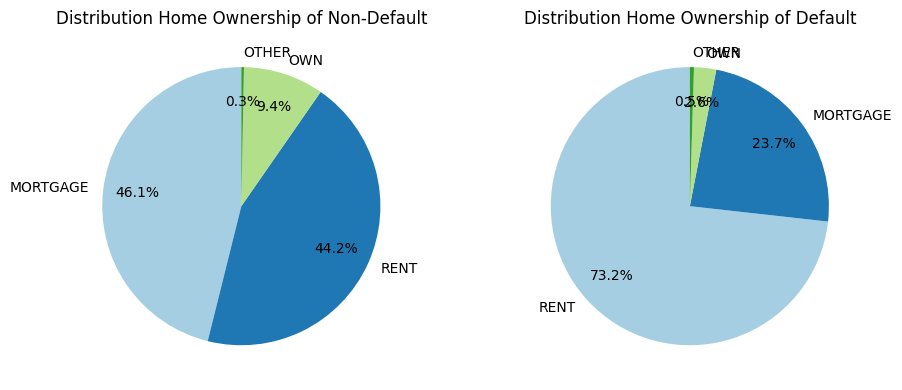

In [41]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

ax[0].pie(
    non_default_home, 
    labels=non_default_home.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Paired.colors,
    pctdistance=0.75,
    labeldistance=1.1
)
ax[0].set_title('Distribution Home Ownership of Non-Default')

ax[1].pie(
    default_home, 
    labels=default_home.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Paired.colors,
    pctdistance=0.75, 
    labeldistance=1.1
)
ax[1].set_title('Distribution Home Ownership of Default')

plt.tight_layout()
plt.show()

- Ada perbedaan antara home ownership antara credit default dan non-default.
- Pada kredit yang gagal bayar, mayoritas nasabah (73.2%) memiliki status kepemilikan rumah sebagai penyewa (rent).
- Sedangkan non default, sebanyak 46% memiliki status kepemilikan rumah dengan KPR dan 44% menyewa.

#### Person Employee Length

In [42]:
df_eda['person_emp_length'].value_counts().head()

person_emp_length
0.0    3305
2.0    3115
3.0    2723
5.0    2375
1.0    2289
Name: count, dtype: int64

<Axes: xlabel='person_emp_length'>

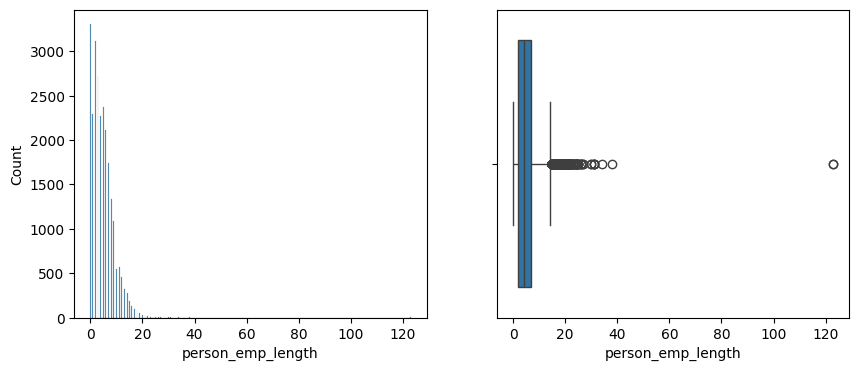

In [43]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda, x='person_emp_length', ax=ax[0])
sns.boxplot(data=df_eda, x='person_emp_length', ax=ax[1])

- Distribusi employee length terlihat skewed.
- Ada nasabah dengan lama kerja > 120 tahun, ini perlu difilter karena nilainya cukup tidak make sense.
- Mayoritas nasabah memiliki lama kerja kurang dari 1 tahun.

<Axes: xlabel='loan_status', ylabel='person_emp_length'>

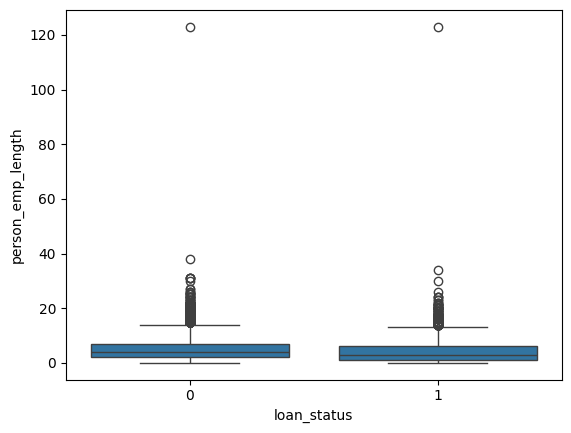

In [44]:
sns.boxplot(data=df_eda, x='loan_status', y='person_emp_length')

- Karena ada outlier, distribusi antara default dan non-default tidak terlihat terlalu jelas, sehingga perlu untuk difilter.

In [83]:
df_eda[df_eda['person_emp_length'] > 40]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.10,N,4,0


<Axes: xlabel='person_emp_length'>

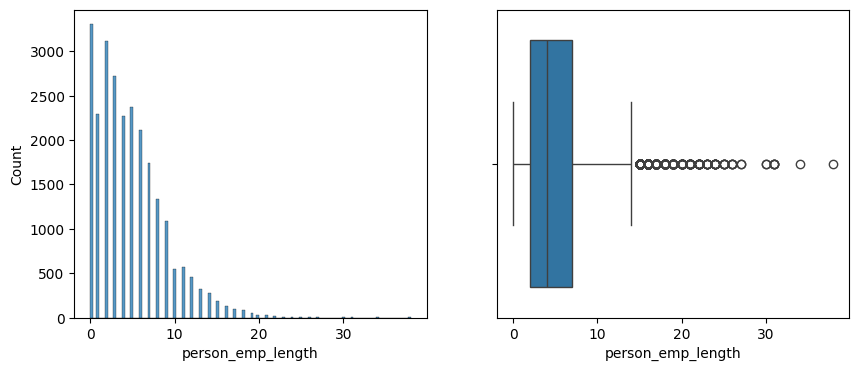

In [84]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda[df_eda['person_emp_length'] < 40], x='person_emp_length', ax=ax[0])
sns.boxplot(data=df_eda[df_eda['person_emp_length'] < 40], x='person_emp_length', ax=ax[1])

<Axes: xlabel='loan_status', ylabel='person_emp_length'>

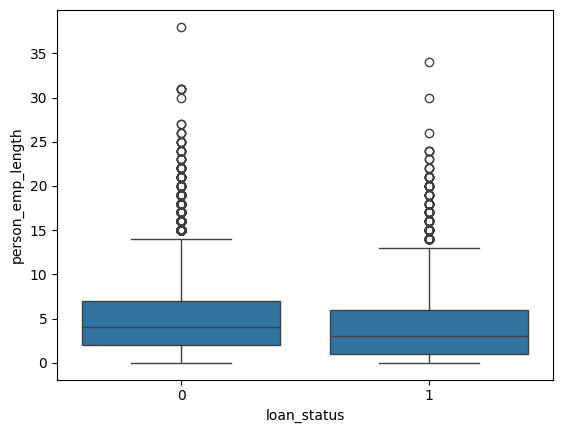

In [85]:
sns.boxplot(data=df_eda[df_eda['person_emp_length'] < 40], x='loan_status', y='person_emp_length')

- Kurang lebih 75% nasabah memiliki lama waktu kerja 0-10 tahun.
- Ada kecenderungan nasabah yang gagal bayar memiliki lama waktu kerja yang lebih pendek, dengan nilai median yang lebih kecil.

#### Loan Intent

In [48]:
df_eda['loan_intent'].value_counts(normalize=True)

loan_intent
EDUCATION            0.197594
MEDICAL              0.186719
VENTURE              0.177773
PERSONAL             0.167978
DEBTCONSOLIDATION    0.161152
HOMEIMPROVEMENT      0.108785
Name: proportion, dtype: float64

<Axes: xlabel='count', ylabel='loan_intent'>

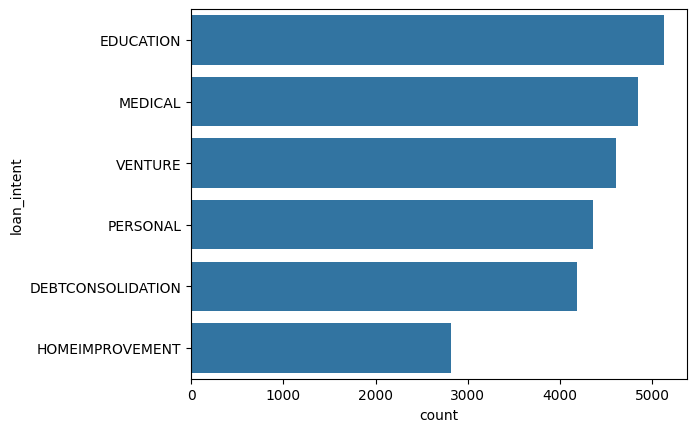

In [49]:
sns.countplot(data=df_eda, y='loan_intent', order=df_eda['loan_intent'].value_counts().index)

- Sebanyak 19.7% nasabah meminjam uang dengan tujuan untuk pendidikan, diikuti dengan 18.6% untuk kesehatan.

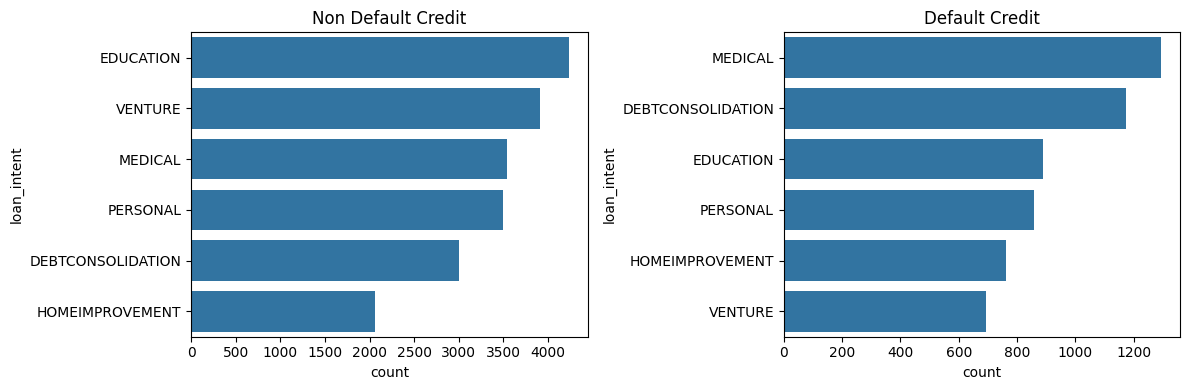

In [50]:
non_default_intent = df_eda[df_eda['loan_status'] == 0]['loan_intent'].value_counts()
default_intent = df_eda[df_eda['loan_status'] == 1]['loan_intent'].value_counts()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
sns.countplot(data=df_eda[df_eda['loan_status'] == 0], y='loan_intent', order=non_default_intent.index, ax=ax[0])
ax[0].set_title('Non Default Credit')

sns.countplot(data=df_eda[df_eda['loan_status'] == 1], y='loan_intent', order=default_intent.index, ax=ax[1])
ax[1].set_title('Default Credit')

plt.tight_layout()
plt.show()

- Pada credit default, sebagian besar tujuan peminjaman adalah untuk kesehatan, konsolidasi hutang dan pendidikan.
- Sedangkan pada credit non default sebagian besar memiliki tujuan pinjaman untuk dana pendidikan, dana usaha, dan uang untuk kesehatan.

#### Loan Grade

In [51]:
df_eda['loan_grade'].value_counts(normalize=True)

loan_grade
A    0.331020
B    0.319489
C    0.199483
D    0.111407
E    0.029500
F    0.007250
G    0.001851
Name: proportion, dtype: float64

<Axes: xlabel='count', ylabel='loan_grade'>

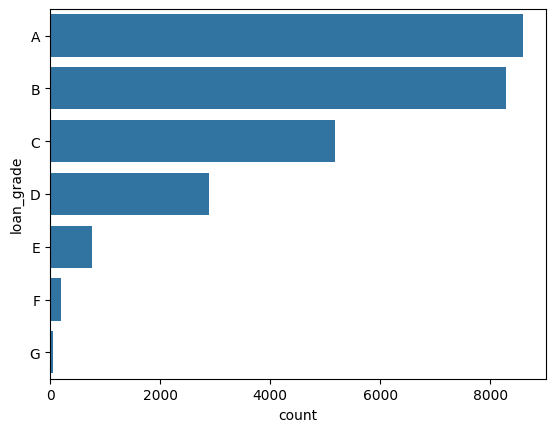

In [52]:
sns.countplot(data=df_eda, y='loan_grade', order=df_eda['loan_grade'].value_counts().index)

- Sebanyak 33% nasabah memiliki credit level A, dan 31% dengan credit level B.
- Hanya 0.1% nasabah dengan credit level terendah, yaitu G.

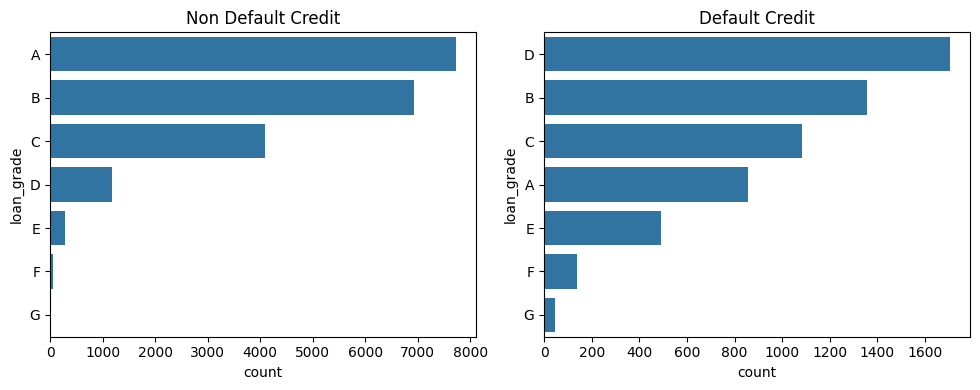

In [53]:
non_default_grade = df_eda[df_eda['loan_status'] == 0]['loan_grade'].value_counts()
default_grade = df_eda[df_eda['loan_status'] == 1]['loan_grade'].value_counts()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.countplot(data=df_eda[df_eda['loan_status'] == 0], y='loan_grade', order=non_default_grade.index, ax=ax[0])
ax[0].set_title('Non Default Credit')

sns.countplot(data=df_eda[df_eda['loan_status'] == 1], y='loan_grade', order=default_grade.index, ax=ax[1])
ax[1].set_title('Default Credit')

plt.tight_layout()
plt.show()

- Nasabah dengan credit default cenderung memiliki credit level yang rendah, yaitu D, B, dan C.
- Sedangkan yang non-default memiliki credit level yang lebih baik, yaitu A, B, dan C.

#### Loan Amount

In [54]:
df_eda['loan_amnt'].value_counts().head()

loan_amnt
10000    2095
5000     1635
12000    1445
6000     1423
15000    1208
Name: count, dtype: int64

<Axes: xlabel='loan_amnt'>

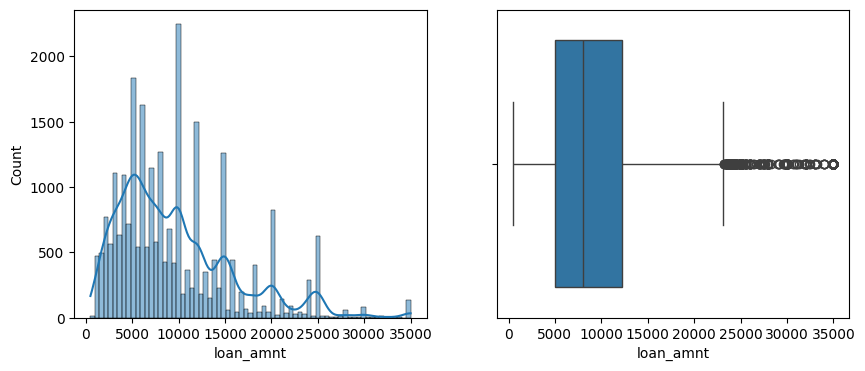

In [55]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda, x='loan_amnt', kde=True, ax=ax[0])
sns.boxplot(data=df_eda, x='loan_amnt', ax=ax[1])

- Distribusi loan amount terlihat skewed, dengan nilai median sekitar $8.000.
- Sebagian besar nasabah meminjam dengan nominal yang genap untuk memudahkan pembayaran, seperti $10.000, $5.000, $12.000, etc.
- Sebagian besar nasabah juga meminjam dengan total amount sebesar $10.000.

<Axes: xlabel='loan_status', ylabel='loan_amnt'>

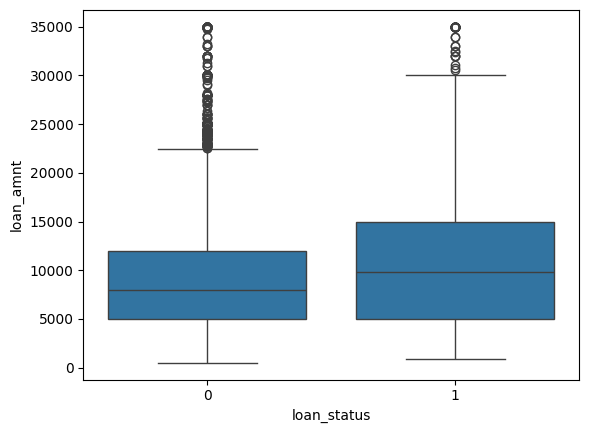

In [56]:
sns.boxplot(data=df_eda, x='loan_status', y='loan_amnt')

- Ada perbedaan dari total pinjaman credit default dan non-default.
- Pada credit default memiliki nilai median total amount yang lebih tinggi dengan rentang yang lebih luas.
- Artinya, total pinjaman dari kredit yang gagal bayar cenderung lebih besar, dengan variasi yang lebih beragam.

#### Loan Interest Rate

In [57]:
df_eda['loan_int_rate'].value_counts().head()

loan_int_rate
7.51     616
10.99    595
7.88     503
7.49     495
7.90     466
Name: count, dtype: int64

<Axes: xlabel='loan_int_rate'>

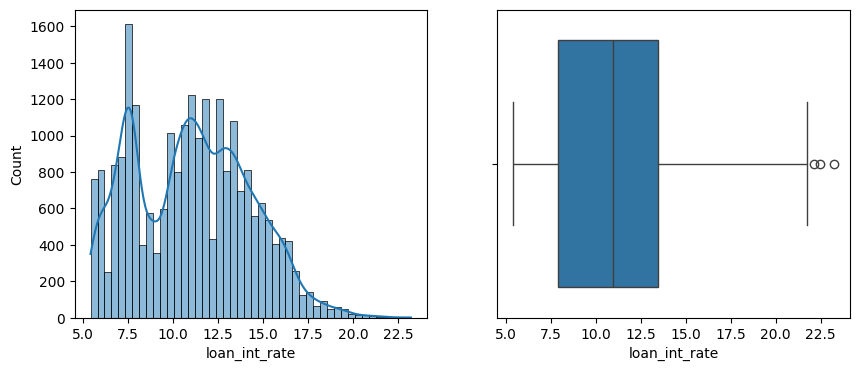

In [58]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda, x='loan_int_rate', kde=True, ax=ax[0])
sns.boxplot(data=df_eda, x='loan_int_rate', ax=ax[1])

- Distribusi loan interest rate terlihat cukup skewed.
- Nilai median sekitar 11.5%, artinya 50% nasabah memiliki bunga pinjaman diatas dan dibawah nilai tersebut.
- Sebagian besar nasabah memiliki bunga pinjaman sebesar 7.51%.

<Axes: xlabel='loan_status', ylabel='loan_int_rate'>

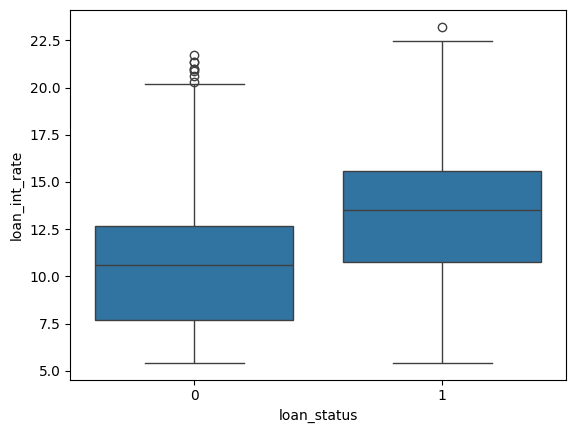

In [59]:
sns.boxplot(data=df_eda, x='loan_status', y='loan_int_rate')

- Ada perbedaan dari bunga pinjaman credit default dan non-default.
- Pada credit default memiliki nilai median interest rate yang lebih tinggi dengan rentang yang lebih luas.
- Artinya, bunga pinjaman dari kredit yang gagal bayar cenderung lebih besar, dengan variasi yang lebih beragam.

#### Loan Percent Income

In [60]:
df_eda['loan_percent_income'].value_counts().head()

loan_percent_income
0.10    1232
0.13    1152
0.08    1151
0.11    1109
0.09    1101
Name: count, dtype: int64

<Axes: xlabel='loan_percent_income'>

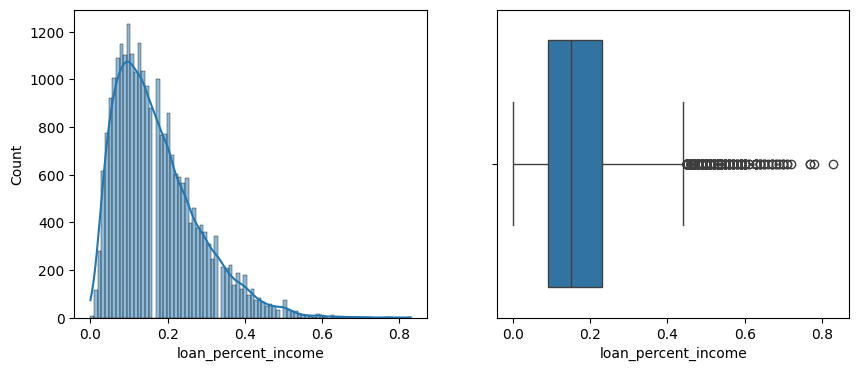

In [61]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda, x='loan_percent_income', kde=True, ax=ax[0])
sns.boxplot(data=df_eda, x='loan_percent_income', ax=ax[1])

- Distribusi loan percent income terlihat skewed, dengan sebagian besar data memiliki loan percent income dari 0-20%.

<Axes: xlabel='loan_status', ylabel='loan_percent_income'>

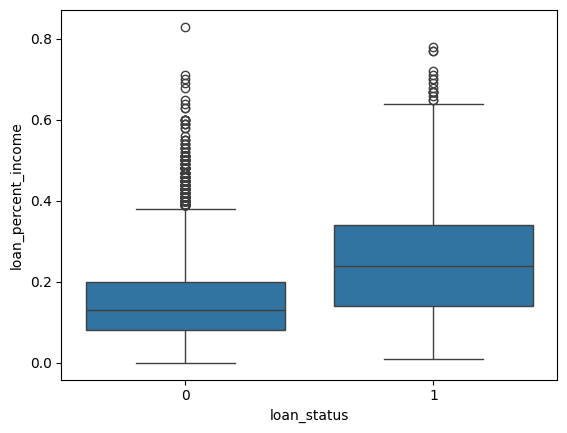

In [62]:
sns.boxplot(data=df_eda, x='loan_status', y='loan_percent_income')

- Ada perbedaan dari loan percent income default dan non-default.
- Pada credit default memiliki nilai median loan percent income yang lebih tinggi dengan rentang yang lebih luas.
- Artinya, persentase pinjaman dari total pendapatan pada kredit yang gagal bayar cenderung lebih besar, dengan variasi yang jauh lebih beragam.

#### Historical Default

In [63]:
df_eda['cb_person_default_on_file'].value_counts(normalize=True)

cb_person_default_on_file
N    0.823346
Y    0.176654
Name: proportion, dtype: float64

<Axes: xlabel='cb_person_default_on_file', ylabel='count'>

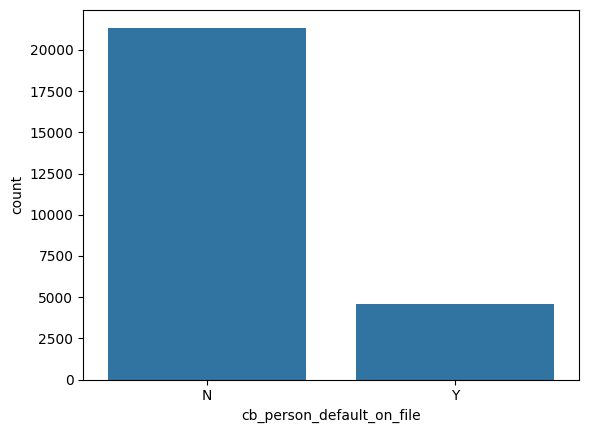

In [64]:
sns.countplot(data=df_eda, x='cb_person_default_on_file')

- Sebanyak 82% nasabah pernah melakukan pinjaman sebelumnya.

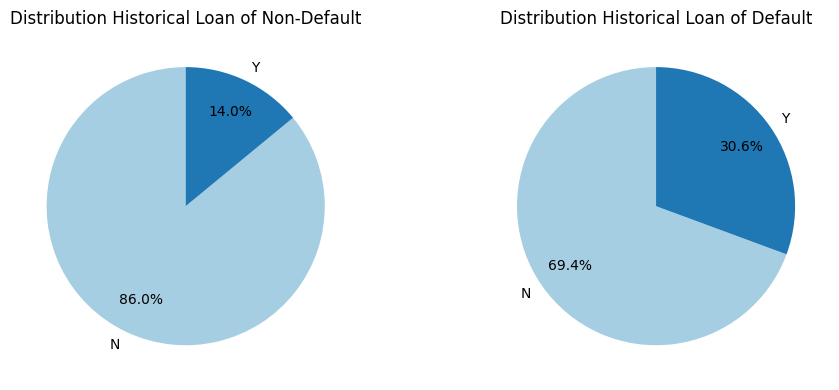

In [86]:
non_default_history = df_eda[df_eda['loan_status'] == 0]['cb_person_default_on_file'].value_counts()
default_history = df_eda[df_eda['loan_status'] == 1]['cb_person_default_on_file'].value_counts()

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

ax[0].pie(
    non_default_history, 
    labels=non_default_history.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Paired.colors,
    pctdistance=0.75,
    labeldistance=1.1
)
ax[0].set_title('Distribution Historical Loan of Non-Default')

ax[1].pie(
    default_history, 
    labels=default_history.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=plt.cm.Paired.colors,
    pctdistance=0.75, 
    labeldistance=1.1
)
ax[1].set_title('Distribution Historical Loan of Default')

plt.tight_layout()
plt.show()

- Pada kredit yang gagal bayar, sebanyak 30.6% pernah memiliki pinjaman sebelumnnya.
- Sedangakan hanya 14% dari kredit yang berhasil bayar telah memiliki pinjaman sebelumnya.

#### Credit History Length

In [66]:
df_eda['cb_person_cred_hist_length'].value_counts().head()

cb_person_cred_hist_length
3    4753
4    4745
2    4723
8    1541
7    1524
Name: count, dtype: int64

<Axes: xlabel='cb_person_cred_hist_length'>

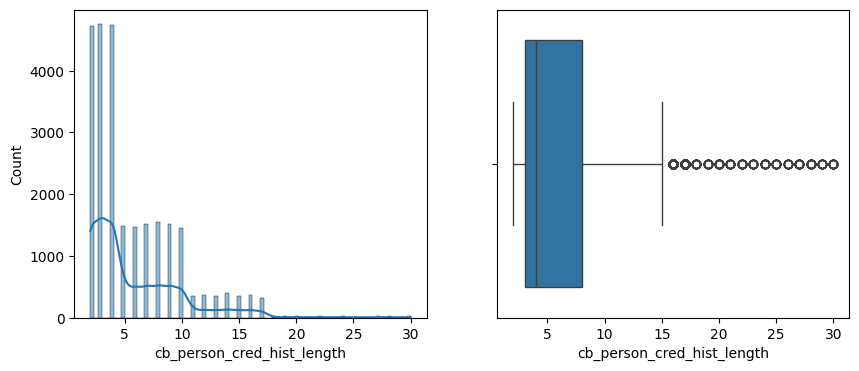

In [67]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
sns.histplot(data=df_eda, x='cb_person_cred_hist_length', kde=True, ax=ax[0])
sns.boxplot(data=df_eda, x='cb_person_cred_hist_length', ax=ax[1])

- Distribusi credit history length terlihat skewed.
- Sebagian besar lama credit sebelumnya adalah 3 tahun.

<Axes: xlabel='loan_status', ylabel='cb_person_cred_hist_length'>

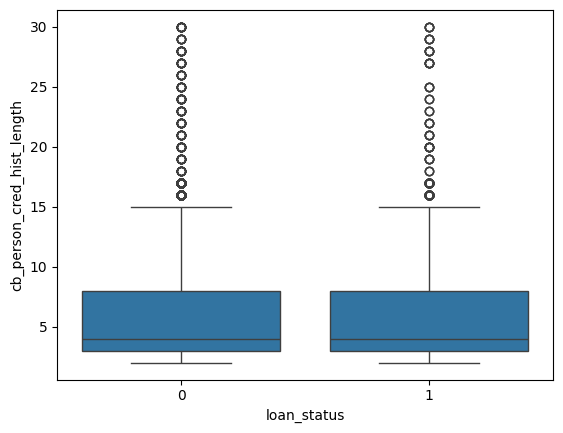

In [68]:
sns.boxplot(data=df_eda, x='loan_status', y='cb_person_cred_hist_length')

- Secara keseluruhan, tidak ada perbedaan yang signifikan dari credit history length credit yang default dan non default.

### Preprocessing

**Task:**
- Handling missing values
- Handling outlier
- Categorical encoding

In [87]:
DATA_INTERIM_PATH = params["dataset_dump_path"]["interim"]
DATA_INTERIM_PATH

'data/interim/'

In [88]:
X_train = joblib.load(DATA_INTERIM_PATH + "X_train.pkl")
y_train = joblib.load(DATA_INTERIM_PATH + "y_train.pkl")

X_test = joblib.load(DATA_INTERIM_PATH + "X_test.pkl")
y_test = joblib.load(DATA_INTERIM_PATH + "y_test.pkl")

X_valid = joblib.load(DATA_INTERIM_PATH + "X_valid.pkl")
y_valid = joblib.load(DATA_INTERIM_PATH + "y_valid.pkl")

#### Handling Missing Values

In [89]:
X_train.isna().sum().sort_values(ascending=False) / len(X_train) * 100

loan_int_rate                 9.594324
person_emp_length             2.803486
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [90]:
X_train[X_train['loan_int_rate'].isnull() | X_train['person_emp_length'].isnull()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
2809,22,54000,RENT,2.0,MEDICAL,A,3000,NaN,0.06,N,4
26830,28,44104,RENT,4.0,VENTURE,B,15000,NaN,0.34,N,10
10841,22,37200,RENT,6.0,PERSONAL,B,10000,NaN,0.27,N,2
22906,28,30000,RENT,4.0,MEDICAL,A,8000,NaN,0.27,N,8
8255,21,56532,MORTGAGE,NaN,EDUCATION,A,16000,7.88,0.28,N,3
...,...,...,...,...,...,...,...,...,...,...,...
29339,36,130000,RENT,11.0,EDUCATION,E,20000,NaN,0.15,Y,14
23579,29,64548,MORTGAGE,3.0,MEDICAL,B,15000,NaN,0.23,N,7
6414,22,33000,RENT,2.0,EDUCATION,D,6000,NaN,0.18,N,4
22869,27,24000,RENT,NaN,EDUCATION,C,8000,12.99,0.33,Y,6


In [91]:
imp_med = SimpleImputer(strategy='median')

# fit to train set
columns_to_impute = ['person_emp_length', 'loan_int_rate']
imp_med.fit(X_train[columns_to_impute])

# transform
X_train[columns_to_impute] = imp_med.transform(X_train[columns_to_impute])
X_valid[columns_to_impute] = imp_med.transform(X_valid[columns_to_impute])
X_test[columns_to_impute] = imp_med.transform(X_test[columns_to_impute])

#### Handling Outliers

In [92]:
train_set = pd.concat([X_train, y_train], axis=1)
valid_set = pd.concat([X_valid, y_valid], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

In [93]:
def calculate_outlier_thres(data, columns):
    thresholds = {}
    
    for col in columns:
        Q1 = np.quantile(data[col], 0.25)
        Q3 = np.quantile(data[col], 0.75)
        IQR = Q3 - Q1
        
        upper_thres = Q3 + 1.5 * IQR
        lower_thres = Q1 - 1.5 * IQR
        
        thresholds[col] = (lower_thres, upper_thres)
    
    return thresholds

In [94]:
thres = calculate_outlier_thres(data=X_train, columns=['person_age', 'person_emp_length'])
thres

{'person_age': (12.5, 40.5), 'person_emp_length': (-5.5, 14.5)}

In [95]:
X_train[X_train['person_emp_length'] > 35]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.10,N,4
32515,53,106000,MORTGAGE,38.0,PERSONAL,B,20000,9.88,0.19,N,23


In [96]:
X_train[X_train['person_age'] > 70]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
747,123,78000,RENT,7.0,VENTURE,B,20000,10.99,0.26,N,4
32381,73,42000,MORTGAGE,7.0,PERSONAL,A,5000,7.49,0.12,N,28
32534,76,75000,RENT,23.0,MEDICAL,A,15000,8.94,0.20,N,25
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2
32521,73,39240,RENT,0.0,MEDICAL,B,1800,12.53,0.05,N,21
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0.11,N,24
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3
32416,94,24000,RENT,1.0,MEDICAL,C,6500,10.99,0.27,N,27


In [97]:
def filter_outlier(data):
    data_copy = data.copy()

    data_copy = data_copy[
        (data_copy['person_emp_length'] <= 35) | 
        (data_copy['person_age'] <= 70)
    ]

    return data_copy

In [98]:
train_set = filter_outlier(data=train_set)
valid_set = filter_outlier(data=valid_set)
test_set = filter_outlier(data=test_set)

In [99]:
def split_input_output(data, column):
    data_copy = data.copy()

    y = data_copy[column]
    X = data_copy.drop(columns=column)

    return X, y

In [100]:
X_train, y_train = split_input_output(data=train_set, column='loan_status')
X_valid, y_valid = split_input_output(data=valid_set, column='loan_status')
X_test, y_test = split_input_output(data=test_set, column='loan_status')

#### Split Categorical-Numerical Columns

In [101]:
def split_num_cat(data: pd.DataFrame, params: dict) -> tuple[pd.DataFrame, pd.DataFrame]:
    # get cat data
    data_cat = data[params["object_columns"]].copy()

    # get num data
    data_num = data[params["feature_num_columns"]].copy()

    return data_cat, data_num

In [102]:
X_train_cat, X_train_num = split_num_cat(data=X_train, params=params)
X_valid_cat, X_valid_num = split_num_cat(data=X_valid, params=params)
X_test_cat, X_test_num = split_num_cat(data=X_test, params=params)

#### One Hot Encoding

In [103]:
def ohe_fit(params: dict):
    for col in params['ohe_columns']:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        ohe.fit(np.array(params['value_' + col]).reshape(-1,1))
        joblib.dump(ohe, params['dataset_dump_path']['processed'] + f'ohe_model_{col}.pkl')

In [104]:
ohe_fit(params=params)

In [105]:
def ohe_transform(data, params):
    data_copy = data.copy()

    for col in params['ohe_columns']:
        ohe = joblib.load(params['dataset_dump_path']['processed'] + f'ohe_model_{col}.pkl')
        ohe_features = ohe.transform(np.array(data_copy[col].to_list()).reshape(-1,1))

        column_name = ohe.get_feature_names_out([col])
        ohe_features = pd.DataFrame(ohe_features, columns=column_name)

        ohe_features.set_index(data_copy.index, inplace=True)
        data_copy = pd.concat([ohe_features, data_copy], axis=1)
        data_copy.drop(columns=col, inplace=True)

    return data_copy

In [106]:
X_train_cat = ohe_transform(data=X_train_cat, params=params)
X_train_cat.head()

,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_grade
7173,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,A
16396,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C
21744,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,A
27805,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,A
24563,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,D


In [107]:
X_valid_cat = ohe_transform(data=X_valid_cat, params=params)
X_test_cat = ohe_transform(data=X_test_cat, params=params)

#### Label Encoding

In [108]:
def custom_label_encoder(data: pd.DataFrame, params: dict) -> pd.DataFrame:
    MAPPER_VALUE = {
        "A": 0,
        "B": 1,
        "C": 2,
        "D": 3,
        "E": 4,
        "F": 5,
        "G": 6
    }

    for col in params["label_encoder_columns"]:
        data[col] = data[col].replace(MAPPER_VALUE)

    return data

In [109]:
X_train_cat_le = custom_label_encoder(data = X_train_cat, params = params)
X_test_cat_le = custom_label_encoder(data = X_test_cat, params = params)
X_valid_cat_le = custom_label_encoder(data = X_valid_cat, params = params)

C:\Users\diana\AppData\Local\Temp\ipykernel_5928\2637487437.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace(MAPPER_VALUE)


In [110]:
X_train_final = pd.concat([X_train_cat_le, X_train_num], axis = 1)
X_test_final = pd.concat([X_test_cat_le, X_test_num], axis = 1)
X_valid_final = pd.concat([X_valid_cat_le, X_valid_num], axis = 1)

In [111]:
DATA_PROCESSED_PATH = params["dataset_dump_path"]["processed"]
DATA_PROCESSED_PATH

'data/processed/'

In [112]:
joblib.dump(X_train_final, DATA_PROCESSED_PATH + "X_train_final.pkl")
joblib.dump(y_train, DATA_PROCESSED_PATH + "y_train_final.pkl")

joblib.dump(X_test_final, DATA_PROCESSED_PATH + "X_test_final.pkl")
joblib.dump(y_test, DATA_PROCESSED_PATH + "y_test_final.pkl")

joblib.dump(X_valid_final, DATA_PROCESSED_PATH + "X_valid_final.pkl")
joblib.dump(y_valid, DATA_PROCESSED_PATH + "y_valid_final.pkl")

['data/processed/y_valid_final.pkl']

### Modeling

In [113]:
X_train_final = load_joblib(path = DATA_PROCESSED_PATH + "X_train_final.pkl")
y_train = load_joblib(path = DATA_PROCESSED_PATH + "y_train_final.pkl")

X_test_final = load_joblib(path = DATA_PROCESSED_PATH + "X_test_final.pkl")
y_test = load_joblib(path = DATA_PROCESSED_PATH + "y_test_final.pkl")

X_valid_final = load_joblib(path = DATA_PROCESSED_PATH + "X_valid_final.pkl")
y_valid = load_joblib(path = DATA_PROCESSED_PATH + "y_valid_final.pkl")

#### Baseline Model

In [114]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf

DummyClassifier(strategy='most_frequent')

In [115]:
dummy_clf.fit(X_train_final, y_train)

DummyClassifier(strategy='most_frequent')

In [116]:
y_pred_dummy = dummy_clf.predict(X_valid_final)

y_pred_dummy

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [117]:
print(f'Accuracy: {accuracy_score(y_valid, y_pred_dummy):.3f}')

Accuracy: 0.781


In [118]:
print(classification_report(y_true = y_valid, y_pred = y_pred_dummy))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4052
           1       0.00      0.00      0.00      1134

    accuracy                           0.78      5186
   macro avg       0.39      0.50      0.44      5186
weighted avg       0.61      0.78      0.69      5186



c:\Users\diana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

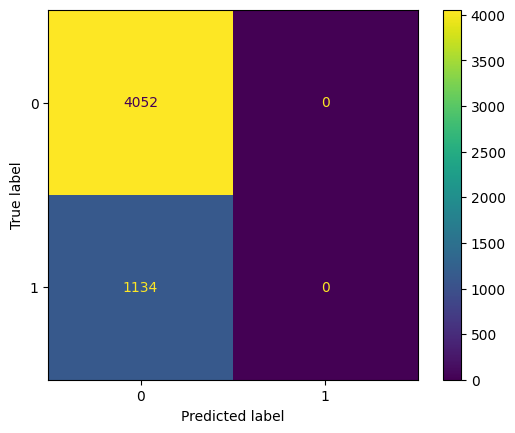

In [119]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_dummy)

#### Vanilla Model

In [120]:
logreg = LogisticRegression()
logreg

LogisticRegression()

In [121]:
# fit or train the data into features train data
logreg.fit(X_train_final, y_train)

c:\Users\diana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [122]:
# make a prediction into validation data for each data point
y_pred_logreg = logreg.predict(X_valid_final)
y_pred_logreg

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [123]:
print(f'Accuracy: {accuracy_score(y_valid, y_pred_logreg):.3f}')

Accuracy: 0.823


In [124]:
print(classification_report(y_true = y_valid, y_pred = y_pred_logreg))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4052
           1       0.69      0.34      0.45      1134

    accuracy                           0.82      5186
   macro avg       0.77      0.65      0.67      5186
weighted avg       0.81      0.82      0.80      5186



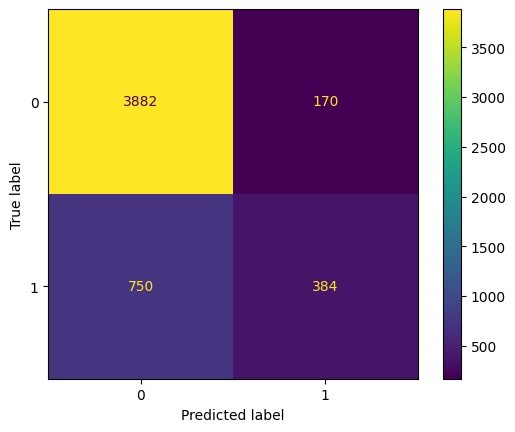

In [125]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_logreg)

#### Multiple Model

In [126]:
# create object for multiple model
dc_baseline = DecisionTreeClassifier()
knn_baseline = KNeighborsClassifier()
rf_baseline = RandomForestClassifier()
svc_baseline = SVC()

In [127]:
dc_baseline.fit(X_train_final, y_train)

DecisionTreeClassifier()

In [128]:
knn_baseline.fit(X_train_final, y_train)

KNeighborsClassifier()

In [129]:
rf_baseline.fit(X_train_final, y_train)

RandomForestClassifier()

In [130]:
svc_baseline.fit(X_train_final, y_train)

SVC()

In [131]:
y_pred_dc = dc_baseline.predict(X_valid_final)
y_pred_knn = knn_baseline.predict(X_valid_final)
y_pred_rf = rf_baseline.predict(X_valid_final)
y_pred_svc = svc_baseline.predict(X_valid_final)

In [132]:
print(f'Accuracy Model Decision Tree: {accuracy_score(y_valid, y_pred_dc):.3f}')
print(f'Accuracy Model KNN: {accuracy_score(y_valid, y_pred_knn):.3f}')
print(f'Accuracy Model Random Forest: {accuracy_score(y_valid, y_pred_rf):.3f}')
print(f'Accuracy Model SVC: {accuracy_score(y_valid, y_pred_svc):.3f}')

Accuracy Model Decision Tree: 0.896
Accuracy Model KNN: 0.843
Accuracy Model Random Forest: 0.935
Accuracy Model SVC: 0.807


In [133]:
print(classification_report(y_true = y_valid, y_pred = y_pred_rf))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4052
           1       0.98      0.72      0.83      1134

    accuracy                           0.94      5186
   macro avg       0.95      0.86      0.89      5186
weighted avg       0.94      0.94      0.93      5186



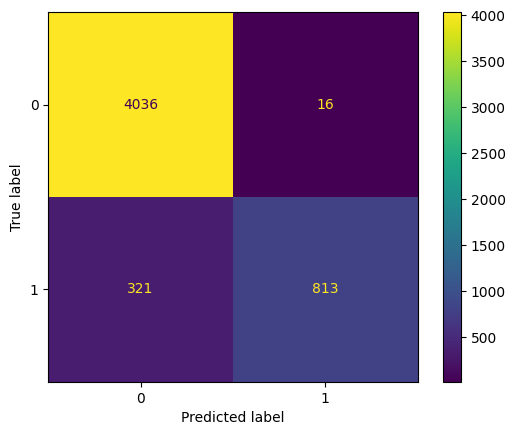

In [134]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_rf)

In [135]:
joblib.dump(rf_baseline, "models/rf_baseline.pkl")

['models/rf_baseline.pkl']

#### Hyperparameter Tuning

In [136]:
# parameter yang ingin kita tuning
PARAMS_RF = {
    'n_estimators' : [50, 100],
    'max_depth' : [10, 20],
    'min_samples_split' : [5, 10]
}

In [137]:
# proses untuk ingin melakukan cross validation berapa kali
k_folds = KFold(n_splits = 5)
k_folds

KFold(n_splits=5, random_state=None, shuffle=False)

In [138]:
best_rf_random = RandomizedSearchCV(
    estimator = rf_baseline,
    param_distributions = PARAMS_RF,
    cv = k_folds,
    verbose = 3
)

In [139]:
best_rf_random.fit(X_train_final, y_train)

c:\Users\diana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=10, min_samples_split=5, n_estimators=50;, score=0.928 total time=   0.6s
[CV 2/5] END max_depth=10, min_samples_split=5, n_estimators=50;, score=0.933 total time=   0.6s
[CV 3/5] END max_depth=10, min_samples_split=5, n_estimators=50;, score=0.928 total time=   0.6s
[CV 4/5] END max_depth=10, min_samples_split=5, n_estimators=50;, score=0.933 total time=   0.5s
[CV 5/5] END max_depth=10, min_samples_split=5, n_estimators=50;, score=0.934 total time=   0.5s
[CV 1/5] END max_depth=10, min_samples_split=5, n_estimators=100;, score=0.928 total time=   1.0s
[CV 2/5] END max_depth=10, min_samples_split=5, n_estimators=100;, score=0.933 total time=   1.1s
[CV 3/5] END max_depth=10, min_samples_split=5, n_estimators=100;, score=0.932 total time=   1.5s
[CV 4/5] END max_depth=10, min_samples_split=5, n_estimators=100;, score=0.933 total time=   1.3s
[CV 5/5] END max_depth=10, min_samples_split=5, n_estimators=10

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [10, 20],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 100]},
                   verbose=3)

In [140]:
best_rf_random.best_params_

{'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 20}

In [141]:
best_rf_tune = RandomForestClassifier(n_estimators=100,  min_samples_split=10, max_depth=20)
best_rf_tune

RandomForestClassifier(max_depth=20, min_samples_split=10)

In [142]:
best_rf_tune.fit(X_train_final, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=10)

In [143]:
y_pred_best = best_rf_tune.predict(X_valid_final)

In [144]:
print(f'Accuracy Best Model: {accuracy_score(y_valid, y_pred_best):.3f}')

Accuracy Best Model: 0.934


In [145]:
print(classification_report(y_true = y_valid, y_pred = y_pred_best))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4052
           1       0.98      0.72      0.83      1134

    accuracy                           0.93      5186
   macro avg       0.95      0.86      0.89      5186
weighted avg       0.94      0.93      0.93      5186



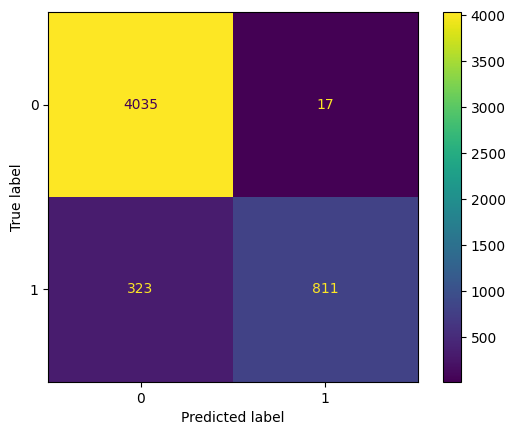

In [146]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_best)

#### Threshold Tuning

In [147]:
y_pred_proba = best_rf_tune.predict_proba(X_valid_final)[:, 1]
y_pred_proba

array([0.97986508, 0.03721773, 0.13181669, ..., 0.99388889, 0.233493  ,
       0.0572575 ])

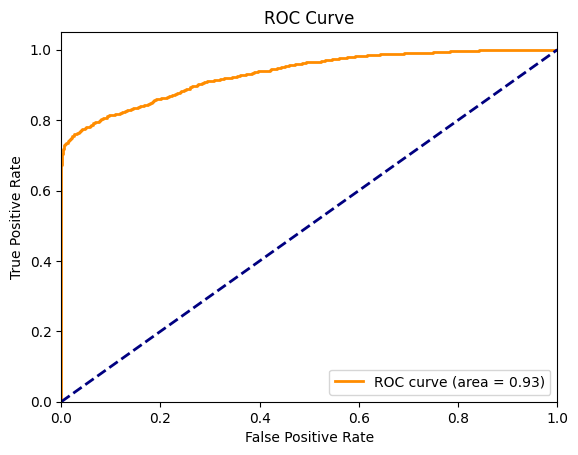

AUC: 0.9319647057389735


In [148]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc}')

In [149]:
thresholds = np.arange(0.1, 1.0, 0.05)

precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

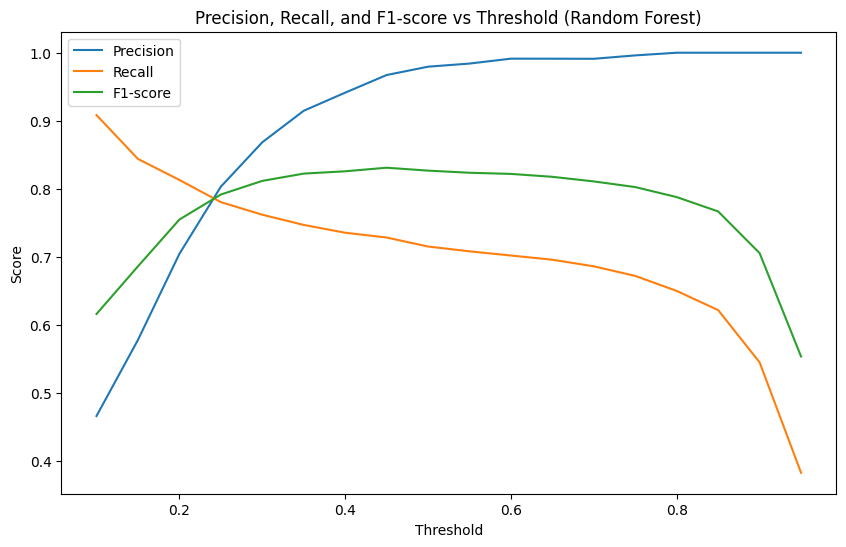

In [150]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold (Random Forest)')
plt.legend()
plt.show()

In [151]:
thresholds = np.arange(0.0, 1.01, 0.01)
f2_scores = []

# Hitung F2-score untuk setiap threshold
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    f2 = fbeta_score(y_valid, y_pred, beta=2)
    f2_scores.append(f2)

# Temukan threshold dengan F2-score tertinggi
optimal_idx = np.argmax(f2_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f2 = f2_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Maximum F2-Score: {optimal_f2}")

Optimal Threshold: 0.2
Maximum F2-Score: 0.7887082976903336


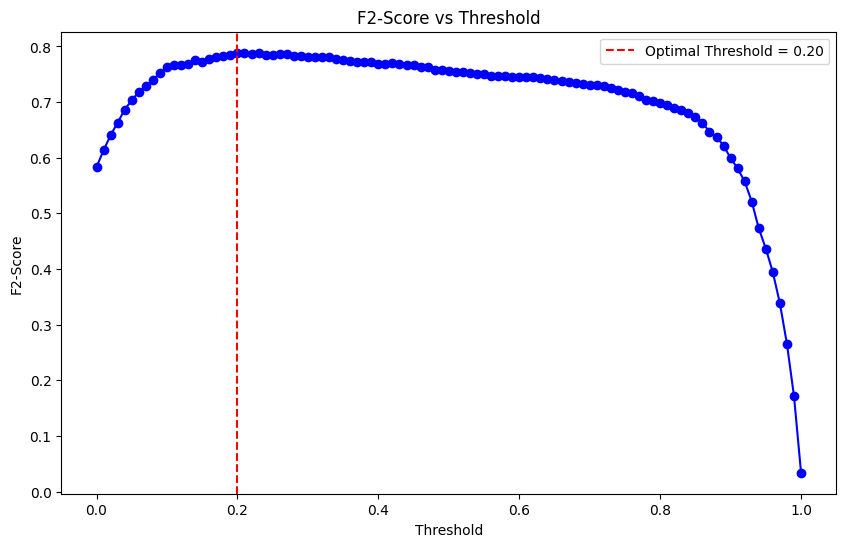

In [152]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f2_scores, marker='o', linestyle='-', color='blue')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.title('F2-Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F2-Score')
plt.legend()
plt.show()

In [153]:
# new threshold
threshold = 0.2
y_pred_thres = (y_pred_proba >= threshold).astype(int)
print(classification_report(y_valid, y_pred_thres))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      4052
           1       0.70      0.81      0.75      1134

    accuracy                           0.88      5186
   macro avg       0.82      0.86      0.84      5186
weighted avg       0.89      0.88      0.89      5186



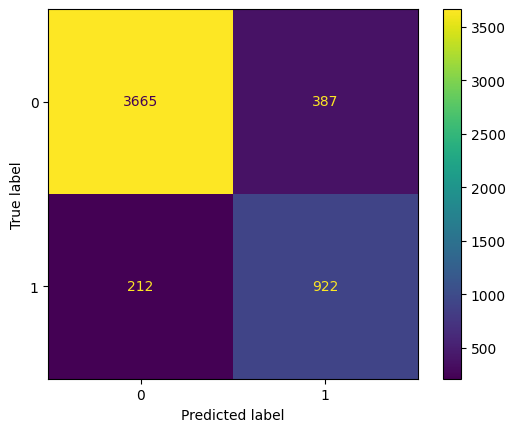

In [155]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_thres)

#### Predict Test Set

In [156]:
y_pred_proba_test = best_rf_tune.predict_proba(X_test_final)[:, 1]
y_pred_thres_test = (y_pred_proba_test >= 0.2).astype(int)

In [157]:
print(f'Accuracy Test Set: {accuracy_score(y_test, y_pred_thres_test):.3f}')

Accuracy Test Set: 0.873


In [158]:
print(classification_report(y_test, y_pred_thres_test))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      1013
           1       0.68      0.80      0.73       284

    accuracy                           0.87      1297
   macro avg       0.81      0.85      0.82      1297
weighted avg       0.88      0.87      0.88      1297



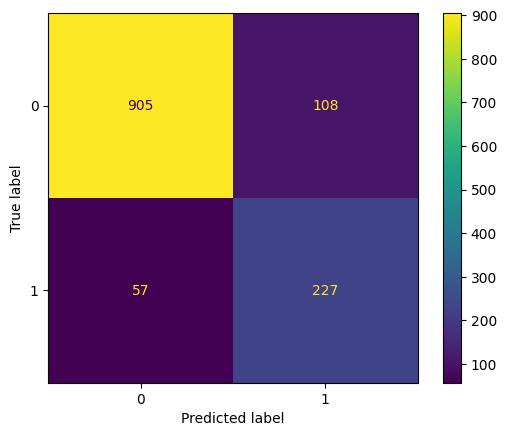

In [159]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thres_test)

In [160]:
joblib.dump(best_rf_tune, "models/rf_best_model_v2.pkl")

['models/rf_best_model_v2.pkl']

### Feature Importance

In [161]:
# get feature importances
feature_importances = best_rf_tune.feature_importances_

for feature, importances in zip(X_train_final.columns, feature_importances):
    print(f'{feature} : {importances}')

cb_person_default_on_file_N : 0.0074936610460380046
cb_person_default_on_file_Y : 0.00720526620861552
loan_intent_DEBTCONSOLIDATION : 0.02482142170791612
loan_intent_EDUCATION : 0.009563803412657257
loan_intent_HOMEIMPROVEMENT : 0.01532971614453122
loan_intent_MEDICAL : 0.023931099030476646
loan_intent_PERSONAL : 0.006852715798907683
loan_intent_VENTURE : 0.008382778359309275
person_home_ownership_MORTGAGE : 0.026130456583834956
person_home_ownership_OTHER : 0.0008302976161227184
person_home_ownership_OWN : 0.02268981050353902
person_home_ownership_RENT : 0.06210412529587861
loan_grade : 0.14128855449234307
person_age : 0.027665787896732838
person_income : 0.14304513313391132
loan_amnt : 0.06150818962560714
cb_person_cred_hist_length : 0.01955140936324991
person_emp_length : 0.04864483237883961
loan_int_rate : 0.09432625959414781
loan_percent_income : 0.24863468180734113


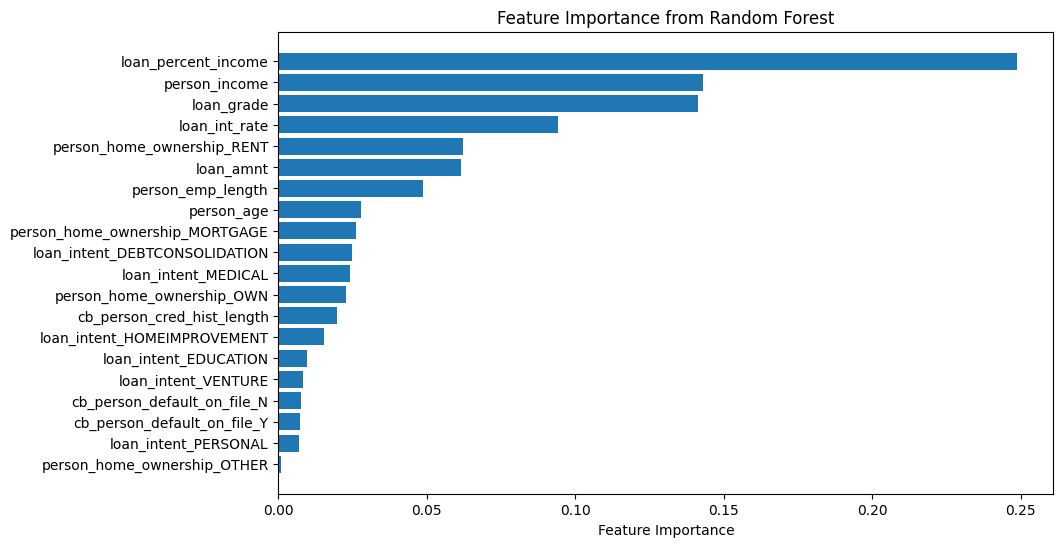

In [162]:
importance_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

#### SHAP

In [164]:
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_rf_tune)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_final)

In [168]:
print("Shape of SHAP values:", np.array(shap_values).shape)
print("Shape of X_test_final:", X_test_final.shape)

Shape of SHAP values: (1297, 20, 2)
Shape of X_test_final: (1297, 20)


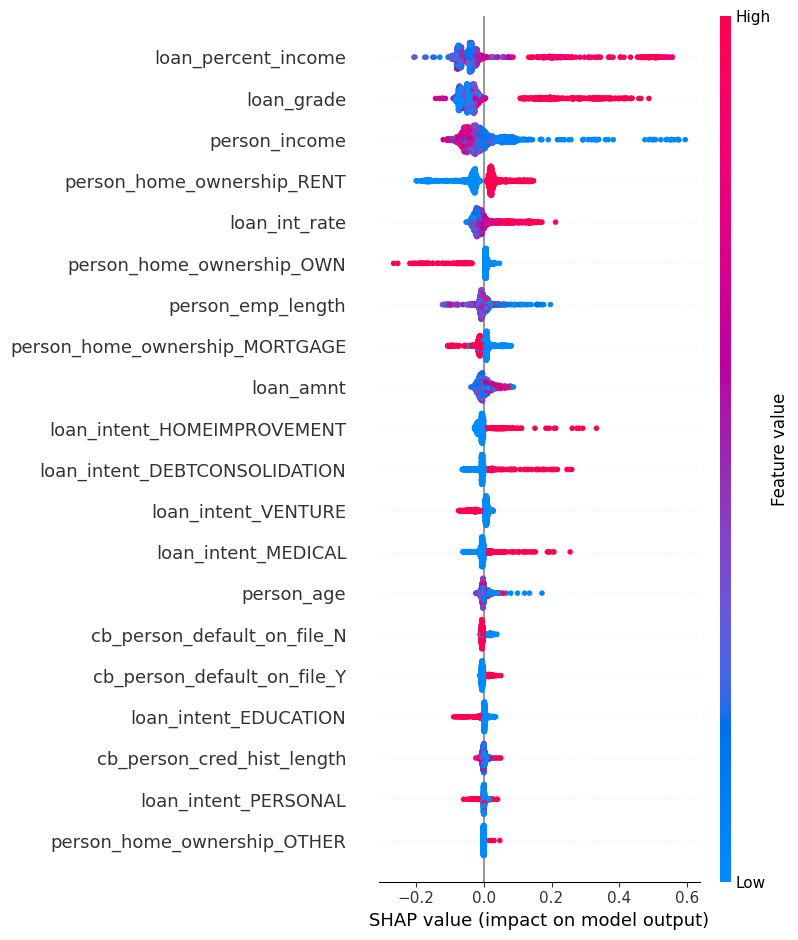

In [169]:
# Generate a SHAP summary plot
shap.summary_plot(shap_values[:, :, 1], X_test_final)

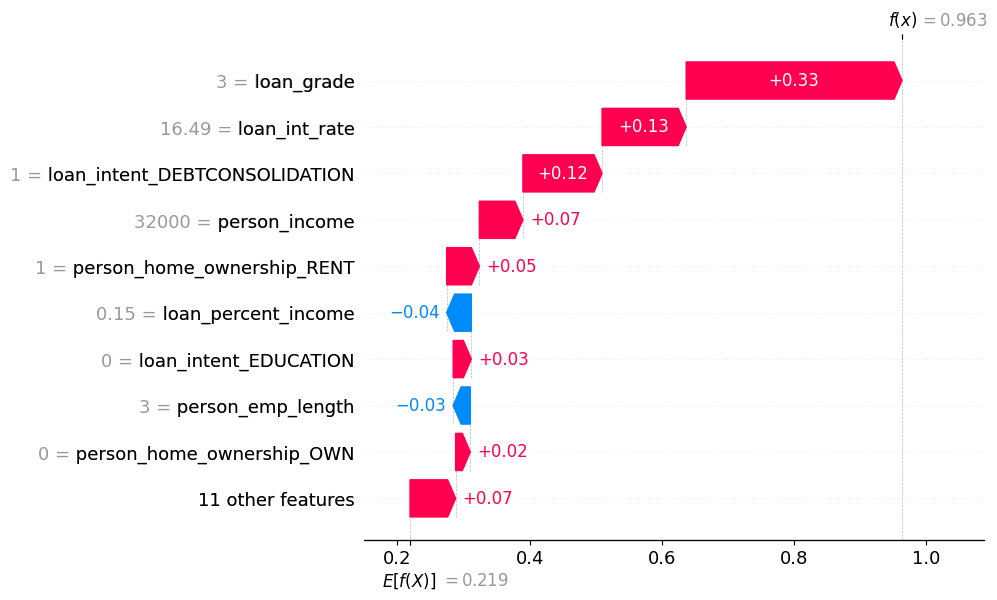

In [195]:
# Generate waterfall plot for a single instance
expected_value = explainer.expected_value[1]
shap_exp = shap.Explanation(
    shap_values[1, :, 1], 
    feature_names=X_test_final.columns.values, 
    data=X_test_final.iloc[1,:], 
    base_values=expected_value
)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_exp)